# Investing Strategy based on Sentiment Analysis of Tweets in X

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import yfinance as yf

### Data Loading and Preprocessing
- Import the X sentiment dataset, establish the index, compute the engagement ratio, and exclude stocks exhibiting insufficient Tweets activity.

In [2]:
def load_and_process_sentiment_data(file_path):
    """
    Load and process sentiment data from a CSV file.

    Parameters:
    file_path (str): Path to the CSV file containing sentiment data.

    Returns:
    pd.DataFrame: Processed sentiment DataFrame with filtered data.
    """
    try:
        # Load data from CSV
        sentiment_df = pd.read_csv(file_path)

        # Check if required columns exist
        required_columns = ['date', 'symbol', 'twitterComments', 'twitterLikes']
        if not all(col in sentiment_df.columns for col in required_columns):
            raise ValueError("CSV file is missing one or more required columns.")

        # Convert 'date' column to datetime
        sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
        if sentiment_df['date'].isna().any():
            print("Warning: Some dates could not be parsed. They have been set to NaT.")

        # Set index and calculate engagement ratio
        sentiment_df.set_index(['date', 'symbol'], inplace = True)
        sentiment_df['engagement_ratio'] = sentiment_df['twitterComments'] / sentiment_df['twitterLikes']

        # Filter data based on criteria
        sentiment_df = sentiment_df[
            (sentiment_df['twitterLikes'] > 20) &
            (sentiment_df['twitterComments'] > 10)
        ]

        return sentiment_df

    except FileNotFoundError:
        raise RuntimeError(f"Error: The file at {file_path} was not found. {e}")
    except pd.errors.EmptyDataError:
        raise RuntimeError(f"Error: The file at {file_path} is empty. {e}")
    except pd.errors.ParserError:
        raise RuntimeError(f"Error: The file at {file_path} could not be parsed. {e}")
    except Exception as e:
        raise RuntimeError(f"An unexpected error occurred: {e}")

In [3]:
file_path = 'X_sentiment_data.csv'
sentiment_df = load_and_process_sentiment_data(file_path)
# print(sentiment_df.head())
sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

### Monthly Aggregation
- Aggregate the sentiment data by month and symbol, and calculate the rank of the average engagement ratio for each month.

In [4]:
def aggregate_and_rank(sentiment_df):
    """
    Aggregate sentiment data by month and calculate engagement ratio rankings.

    Parameters:
    sentiment_df (pd.DataFrame): DataFrame containing sentiment data with 'engagement_ratio'.

    Returns:
    pd.DataFrame: Aggregated DataFrame with engagement ratio rankings.
    """
    try:
        if sentiment_df.empty:
            raise ValueError("The input DataFrame is empty.")

        if 'engagement_ratio' not in sentiment_df.columns:
            raise ValueError("The input DataFrame does not contain the 'engagement_ratio' column.")

        # Aggregate by month and symbol, then calculate mean engagement ratio
        aggregated_df = (
            sentiment_df
            .reset_index('symbol')
            .groupby([pd.Grouper(freq = 'ME'), 'symbol'])
            [['engagement_ratio']].mean()
            )

        # Rank engagement ratios within each month
        aggregated_df['rank'] = (
            aggregated_df
            .groupby(level = 0)
            ['engagement_ratio'].transform(lambda x: x.rank(ascending = False)))

        return aggregated_df

    except Exception as e:
        raise RuntimeError(f"An unexpected error occurred: {e}")

In [5]:
aggregated_df = aggregate_and_rank(sentiment_df)
# print(aggregated_df.head())
aggregated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

### Monthly Selection of Top 5 Stocks Based on Cross-Sectional Rankings
- Select the top five stocks for each month based on their rankings, with the selection period beginning at the start of the following month.

In [6]:
def filter_and_adjust_df(aggregated_df):
    """
    Filter the DataFrame based on rank and adjust index for analysis.

    Parameters:
    aggregated_df (pd.DataFrame): DataFrame with aggregated data and rankings.

    Returns:
    pd.DataFrame: Adjusted DataFrame with filtered data and updated index.
    """
    try:
        if 'rank' not in aggregated_df.columns:
            raise ValueError("The DataFrame must contain a 'rank' column.")

        if 'date' not in aggregated_df.index.names or 'symbol' not in aggregated_df.index.names:
            raise ValueError("The DataFrame index must include 'date' and 'symbol'.")

        # Filter rows where rank is less than 6
        filtered_df = aggregated_df[aggregated_df['rank'] < 6].copy()

        # Adjust index directly
        filtered_df = filtered_df.reset_index(level = 1)

        # Shift date index by one day
        filtered_df.index = filtered_df.index + pd.DateOffset(1)

        # Reset index and set it to ['date', 'symbol']
        filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

        return filtered_df

    except Exception as e:
        raise RuntimeError(f"An unexpected error occurred: {e}")

In [7]:
filtered_df = filter_and_adjust_df(aggregated_df)
# print(filtered_df.head())
filtered_df

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
...                             ...   ...
2023-02-01 A               0.471572   5.0
           AES             0.533809   4.0
           BIIB            0.839303   1.0
           FCX             0.667387   3.0
           MDT             0.806841   2.0

[75 rows x 2 columns]

### Formulate Portfolios at the Beginning of Each Month
- Construct a dictionary that maps the start of each month to the corresponding stocks selected for the portfolio.

In [8]:
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

In [9]:
def create_fixed_dates(filtered_df):
    """
    Create a dictionary mapping dates to lists of tickers from the filtered DataFrame.

    Parameters:
    filtered_df (pd.DataFrame): DataFrame with a multi-level index including 'date'.

    Returns:
    dict: Dictionary with dates as keys and lists of tickers as values.
    """
    try:
        # Check if 'date' is in index levels
        if 'date' not in filtered_df.index.names:
            raise ValueError("The DataFrame index must include 'date'.")

        # Generate the dictionary using groupby and apply
        fixed_dates = (
            filtered_df
            .groupby(level = 'date')
            .apply(lambda x: x.index.get_level_values('symbol').tolist())
            .to_dict()
            )

        # Convert the datetime index to string format
        fixed_dates = {d.strftime('%Y-%m-%d'): tickers for d, tickers in fixed_dates.items()}

        return fixed_dates

    except Exception as e:
        raise RuntimeError(f"An unexpected error occurred: {e}")



In [10]:
fixed_dates = create_fixed_dates(filtered_df)
# print(fixed_dates)
fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

### Calculate Portfolio Returns with Monthly Rebalancing Using Updated Prices for Selected Stocks
- Download the latest stock prices for shortlisted stocks for each month to calculate and rebalance portfolio returns.

In [11]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers = stocks_list, start = '2021-01-01', end = '2023-03-01')

[*********************100%%**********************]  85 of 85 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


In [12]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df2 = yf.download(tickers = stocks_list, start = '2021-01-01', end = '2023-03-01')

[*********************100%%**********************]  85 of 85 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


In [13]:
def download_stocks_data(stocks_list, start_date, end_date, chunk_size = 100):
    """
    Download stock data for a list of stocks in chunks to avoid API rate limits.

    Parameters:
    stocks_list (list): List of stock symbols to download data for.
    start_date (str): Start date for the data download in 'YYYY-MM-DD' format.
    end_date (str): End date for the data download in 'YYYY-MM-DD' format.
    chunk_size (int): Number of stock symbols to fetch in each chunk. Default is 50.

    Returns:
    pd.DataFrame: DataFrame with the downloaded stock data.
    """
    all_data = []

    # Check if stocks_list is empty
    if not stocks_list:
        raise ValueError("The stocks list is empty. No data to download.")

    # Download data in chunks
    for i in range(0, len(stocks_list), chunk_size):
        chunk = stocks_list[i:i + chunk_size]
        try:
            data = yf.download(tickers = chunk, start = start_date, end = end_date)
            all_data.append(data)
        except Exception as e:
            raise RuntimeError(f"Error downloading data for stocks {chunk}: {e}")

    # Concatenate all chunks into a single DataFrame
    if all_data:
        combined_data = pd.concat(all_data, axis = 1)
        return combined_data
    else:
        raise RuntimeError("Failed to download data for the provided stock list.")

In [14]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()
prices_df = download_stocks_data(stocks_list, start_date = '2021-01-01', end_date = '2023-03-01')
# print(prices_df.head())
prices_df

[*********************100%%**********************]  85 of 85 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Price        Adj Close                                                         \
Ticker               A    AAL         AAP        AAPL        ABBV         ABT   
Date                                                                            
2021-01-04  115.980751  15.13  144.788574  126.683441   90.489502  102.054939   
2021-01-05  116.928993  15.43  144.632156  128.249725   91.425217  103.317642   
2021-01-06  120.135483  15.52  152.987778  123.932640   90.635445  103.102524   
2021-01-07  123.332169  15.38  154.294540  128.161636   91.605484  104.103348   
2021-01-08  124.212006  15.13  156.493851  129.267807   92.086227  104.393303   
...                ...    ...         ...         ...         ...         ...   
2023-02-22  140.565460  15.56  139.062637  147.747757  142.166794   99.620407   
2023-02-23  141.673538  15.87  137.503723  148.233932  143.487778   99.484604   
2023-02-24  139.694824  15.56  134.444031  145.564926  144.091660   97.457069   
2023-02-27  140.664383  15.63  136.167511  146.765472  145.573044   96.787689   
2023-02-28  140.456635  15.98  140.360123  146.259445  145.214493   98.679405   

Price                                                    ...   Volume  \
Ticker            AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  70.949341  20.735622  148.095840  92.300003  ...  5732800   
2021-01-05  70.853630  21.431566  158.089828  92.769997  ...  4029500   
2021-01-06  71.419205  22.288115  169.898315  90.330002  ...  3612500   
2021-01-07  69.513649  22.065056  178.533890  95.160004  ...  3993700   
2021-01-08  68.895859  22.680704  178.630966  94.580002  ...  3104200   
...               ...        ...         ...        ...  ...      ...   
2023-02-22  85.452385  24.015274  242.647400  76.610001  ...  2044600   
2023-02-23  85.348892  24.015274  249.933258  79.750000  ...  2066600   
2023-02-24  85.085442  23.949062  245.670059  78.089996  ...  2875100   
2023-02-27  84.746727  23.532887  253.054291  78.769997  ...  2459700   
2023-02-28  82.770844  23.343718  250.386108  78.580002  ...  3662300   

Price                                                                          \
Ticker         REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   
...             ...       ...      ...       ...      ...        ...      ...   
2023-02-22   415500   9181100  1092200  25308800  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700  24845800  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900  29138100   852600  142228100  2439300   
2023-02-27   557100   6287000   608200  22981100  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900  34154800  1188800  153144900  3556300   

Price                           
Ticker             V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 510 columns]

In [15]:
def calculate_portfolio_returns(prices_df, fixed_dates):
    """
    Calculate the portfolio returns based on fixed dates and stock returns.

    Parameters:
    prices_df (pd.DataFrame): DataFrame with stock prices.
    fixed_dates (dict): Dictionary with start dates as keys and lists of tickers as values.

    Returns:
    pd.DataFrame: DataFrame with portfolio returns.
    """
    try:
        # Check if necessary columns exist
        if 'Adj Close' not in prices_df.columns:
            raise ValueError("The 'Adj Close' column is missing from the DataFrame.")

        # Calculate daily returns
        returns_df = np.log(prices_df['Adj Close']).diff()

        portfolio_df = pd.DataFrame()

        for start_date in fixed_dates.keys():
            end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
            cols = fixed_dates[start_date]
            # Filter and calculate mean returns
            temp_df = returns_df[start_date: end_date][cols].mean(axis = 1).to_frame('portfolio_return')
            portfolio_df = pd.concat([portfolio_df, temp_df], axis = 0)

        return portfolio_df

    except Exception as e:
        raise RuntimeError(f"An unexpected error occurred: {e}")

In [16]:
portfolio_df = calculate_portfolio_returns(prices_df, fixed_dates)
# print(portfolio_df.head())
portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


### Download NASDAQ Prices and Calculate Returns for Strategy Comparison
- Retrieve the latest prices for NASDAQ and calculate their returns to benchmark against our investment strategy.

In [17]:
def fetch_and_merge_nasdaq_data(portfolio_df, start_date, end_date):
    """
    Fetches NASDAQ data and merges it with the provided portfolio DataFrame.

    Parameters:
    portfolio_df (pd.DataFrame): DataFrame containing portfolio returns.
    start_date (str): Start date for the NASDAQ data download.
    end_date (str): End date for the NASDAQ data download.

    Returns:
    pd.DataFrame: Updated portfolio DataFrame with NASDAQ returns merged.
    """
    try:
        # Download NASDAQ data
        nasdaq_df = yf.download(tickers = 'QQQ', start = start_date, end = end_date)

        # Check if the download was successful and contains the required column
        if 'Adj Close' not in nasdaq_df.columns:
            raise ValueError("The 'Adj Close' column is missing from the NASDAQ data.")

        # Calculate daily returns
        nasdaq_returns = np.log(nasdaq_df['Adj Close']).diff().to_frame('nasdaq_return')

        # Merge with the existing portfolio DataFrame
        portfolio_df = portfolio_df.merge(nasdaq_returns, left_index = True, right_index = True)

        return portfolio_df

    except Exception as e:
        raise RuntimeError(f"An unexpected error occurred: {e}")



In [18]:
portfolio_df = fetch_and_merge_nasdaq_data(portfolio_df, start_date = '2021-01-01', end_date = '2023-03-01')
# print(portfolio_df.head())
portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


In [19]:
def plot_cumulative_returns(portfolio_df):
    """
    Plot the cumulative returns of the portfolio strategy over time.

    Parameters:
    portfolio_df (pd.DataFrame): DataFrame containing portfolio returns.
    """
    try:
        # Check if the DataFrame is empty
        if portfolio_df.empty:
            raise ValueError("The portfolio DataFrame is empty. No data to plot.")

        # Calculate cumulative returns
        portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

        # Plotting
        plt.style.use('ggplot')
        plt.figure(figsize = (21, 9))
        portfolios_cumulative_return.plot(figsize = (21, 9))

        plt.title('Performance of X Sentiment Analysis Strategy Compared to Nasdaq', fontsize = 16, weight = 'bold')
        plt.xlabel('Date', fontsize = 14)
        plt.ylabel('Cumulative Return', fontsize = 14)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
        plt.grid(True, linestyle = '--', alpha = 1)

        plt.legend(['Portfolio Return', 'Nasdaq Return'], loc = 'upper left', fontsize = 12)
        plt.tight_layout()

        plt.show()

    except Exception as e:
        raise RuntimeError(f"An unexpected error occurred: {e}")

<Figure size 2100x900 with 0 Axes>

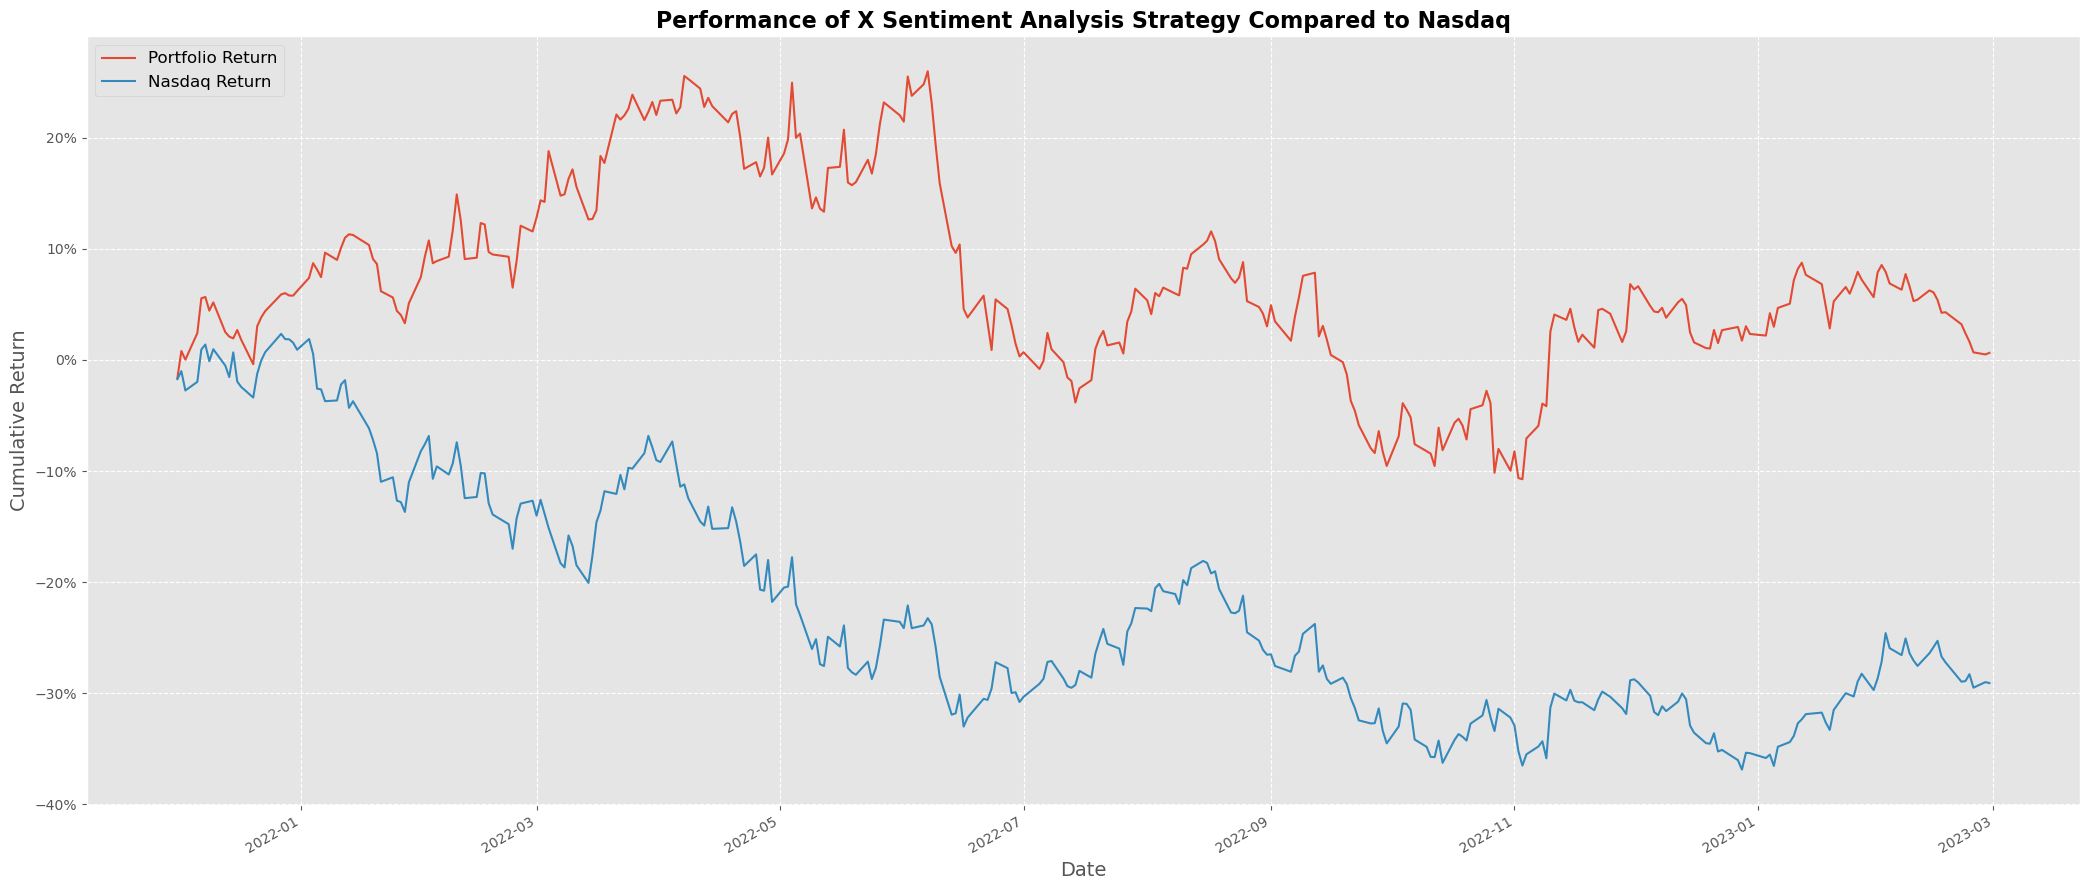

In [20]:
plot_cumulative_returns(portfolio_df)